In [19]:
import jax.numpy as np
from jax import jit
from discopy import Tensor
Tensor.np = np
import discopy
from discopy import Word, Ty, Cup, Id, grammar
from sympy.abc import phi
from time import time
from discopy.grammar import brute_force
import numpy as np
from discopy import drawing
from discopy.quantum import Id, Rz, CX, CRz
from sympy.abc import symbols, phi
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP,circuit, Bra, Ry
from discopy import CircuitFunctor, qubit, Functor
from sympy import default_sort_key


# Spam Classification for Email

Here we generate a vocabulary of words with positional tags.  This is translated into a set of data with correct, and incorrect sentences which correspond to lables 1's and 0's respectively.  This data is split up into a training,development, and test set.  The sentences are translated along with their grammer are translated into diagrams with discopy, and then into corresponding parameterized quantum circuits.  We then use the data labels and  a classical optimizer to optimize these circuits, and then calculate a classification value 1 or 0 for each sentence.  This allows use to test different sentences of similar for, but with different vocabulary to identify spam vs real email sentences for example.

1. [Task 2: Generating Vocabulary](#1.-Task-2)
2. [Data Sets](#2.-Datasets)
3. [Generating Templates](#3.-Generating-Templates)
4. [Task 3: Experiment](#4.-Task-3:-Experiment)

# 1. Task 2

Below we generate the vocabulary, grammer, and corresponding labels that we want to test

In [20]:
#******************************************
# Generate your corpus
#******************************************
# sentences can be of the `word1 word2 word3 ...`
# if you are generating the diagrams using templates
# then you may want to consider adding POS tags (N, V, Adj) for each word
# labels should be of the form [0,1] or [1,0] for binary classification

s, n = Ty('s'), Ty('n')
Jaz = Word('Jaz', n)
Janezesa = Word('Janezesa', n)
Juniper = Word('Juniper', n)
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
despises = Word('depises', n.r @ s @ n.l)
tolerates = Word('tolerdfates', n.r @ s @ n.l)
pinches = Word('pinches', n.r @ s @ n.l)
attacks = Word('attacks', n.r @ s @ n.l)
flees = Word('flees', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob,Jaz,Janezesa,Juniper,despises,tolerates,pinches,attacks,flees]#, who, is_rich]

num_sentences = 26

gen, n_sentences = brute_force(*vocab), num_sentences
sentences= list()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word))
    sentences.append(sentence)
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice loves Alice
Alice loves Bob
Alice loves Jaz
Alice loves Janezesa
Alice loves Juniper
Alice depises Alice
Alice depises Bob
Alice depises Jaz
Alice depises Janezesa
Alice depises Juniper
Alice tolerdfates Alice
Alice tolerdfates Bob
Alice tolerdfates Jaz
Alice tolerdfates Janezesa
Alice tolerdfates Juniper
Alice pinches Alice
Alice pinches Bob
Alice pinches Jaz
Alice pinches Janezesa
Alice pinches Juniper
Alice attacks Alice
Alice attacks Bob
Alice attacks Jaz
Alice attacks Janezesa
Alice attacks Juniper
Alice flees Alice

0.17 seconds to generate 26 sentences.


## 2. Datasets
Here we auto split our data sentences into a train,dev, and test set allong with corresponding labels sets for each.

In [130]:
hl = int(num_sentences/4)
hlp = 3*hl

train_sentences = sentences[0:hlp]
hd = int((num_sentences - hlp)/2)
dev_sentences = sentences[hlp:hlp+hd]
test_sentences = sentences[hlp+hd:]

train_labels = [1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,1,1]
dev_labels = [0,1,1,1]
test_labels = [1,0,1,1]

train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

# 3. Generating Templates

Another option is to generate the diagrams via the website: https://qnlp.cambridgequantum.com/generate.html.

We also, generate our own Ansatz states below, but you can also use the builtin Ansatz with the IQP Ansatz method:

https://discopy.readthedocs.io/en/main/discopy/quantum.circuit.html.


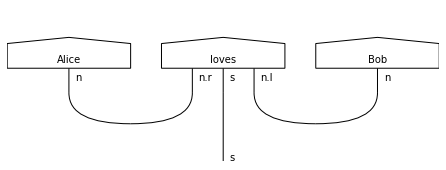

In [131]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

def sentence2diagram(one_sentence):
    w0,w1,w2 = one_sentence.split(' ')
    words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    return words >> cups

train_diagrams = [sentence2diagram(s) for s in train_sentences]
dev_diagrams = [sentence2diagram(s) for s in dev_sentences]
test_diagrams = [sentence2diagram(s) for s in test_sentences]

def NVN_example(w0, w1, w2):
    words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    return words >> cups

grammar.draw(sentence2diagram(train_sentences[1]))

Here we define our ansatz and use a functor to translate our sentence into a quantum circuit with two possible parameters $\phi$ and $abc$.

Alice loves Alice


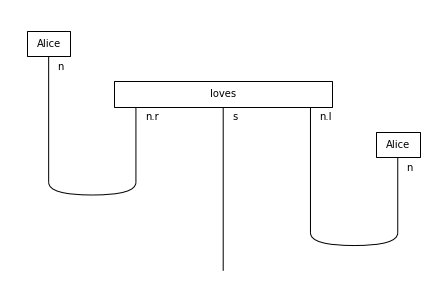

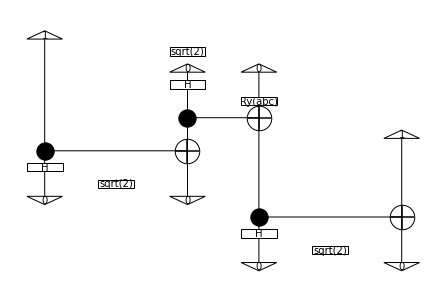

In [132]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.


# Ansatz for words with type `n`, e.g. 'Alice', 'Bob'

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

# Ansatz for words with type `n.r @ s @ n.l`, e.g. 'loves'
def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

def transitive_ansatz1(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Ry(phase) >> CX

def transitive_ansatz2(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

def transitive_ansatz3(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX


GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)
sym = symbols("abc")
params0 = np.array([0.5, 1.0])
#params0 = np.array([0.5])


diagram2circuit = circuit.Functor(
    ob={s: qubit ** 0, n: qubit ** 1},
    ar={Alice: Ket(1),
        flees: transitive_ansatz(phi),
        loves: transitive_ansatz1(sym),
        tolerates:transitive_ansatz2(sym),
        despises:transitive_ansatz(phi),
        pinches:transitive_ansatz3(sym),
        attacks:transitive_ansatz(sym),
        Janezesa:Ket(0),
        Juniper:Ket(1),
        Jaz:Ket(1),
        Bob: Ket(1),
        who: GHZ,
        is_rich: intransitive_ansatz(params0[0])})

train_circuits = [diagram2circuit(d) for d in train_diagrams]
dev_circuits = [diagram2circuit(d) for d in dev_diagrams]
test_circuits = [diagram2circuit(d) for d in test_diagrams]

print(train_sentences[0])
train_diagrams[0].draw()
train_circuits[1].draw()
# for i in range(len(train_circuits)):   #drawing out all the diagrams
#     circ = train_circuits[i]
#     print(sentences[i],i)
#     train_diagrams[i].draw()
#     circ.draw()

# 4. Task 3: Experiment

Here we do an experiment to train our circuits and classify them as spam or not.

In [133]:
# These imports will come in handy when you want to run
# backend simulations.

# from qiskit import IBMQ
# from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

In [134]:
#******************************************
# Counting parameters in your model
#******************************************
circuits = train_circuits + dev_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.
parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)

import jax.numpy as jnp

In [156]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = jnp.abs(predicts - 1e-9)

    predicts = predicts / predicts.sum()

    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)
    cost = [predicts[i]**2-labels[i]**2 for i in range(len(predicts))]
    cost = sum(cost)
    return cost

In [157]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = jnp.array([
            normalise(jnp.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
        return predictions

    return pred_fn

In [158]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
# onp.random.seed(0)


x0 = jnp.array(onp.random.random(len(parameters)))

print(x0)
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

[0.3190093  0.46468547]
Performing Just-In-Time compilation, this may take a while...


DeviceArray([[1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [159]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [152]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [153]:
from noisyopt import minimizeSPSA
minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=2000, callback=dev_cost_fn)

     fun: DeviceArray([7.], dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 4000
     nit: 2000
 success: True
       x: DeviceArray([0.58787096, 0.612689  ], dtype=float32)

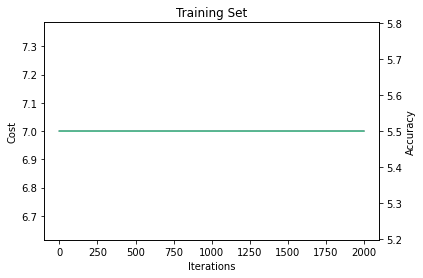

In [154]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

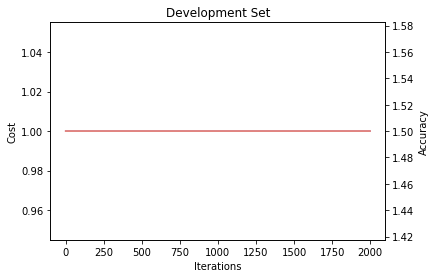

In [155]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

In [162]:
# when you are happy with the development set results
# run your model on the testing set

for p in callback_params:
    test_cost_fn(p)

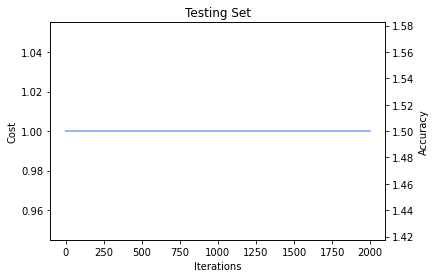

In [163]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()

# 5. Running on IBM AER

In [185]:
from pytket.extensions.qiskit import tk_to_qiskit
def evaluate(params, sentences, input_circuits,backend, n_shots=2**10, seed=0):
    circuits =[np.abs(cir.lambdify(*parameters)(*params).eval().array)for cir in input_circuits]
    #circuits = input_circuits
    results = [Circuit.eval(
                circuit,
                backend=backend,
                n_shots=n_shots,
                seed=seed,
                compilation=backend.default_compilation_pass(2)) for circuit in circuits]
    tensors = [np.abs(result.array)[0] for result in results]
    return tensors

In [186]:
from pytket.extensions.qiskit import AerBackend

start = time()
corpus = dict(zip(train_circuits, evaluate(params0, train_sentences,train_circuits, backend=AerBackend())))
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

delta = .01

print("True sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar > .5 + delta)))
print("False sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar < .5 - delta)))
print("Maybe sentences:\n{}".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if .5 - delta <= scalar <= .5 + delta)))

AttributeError: 'numpy.ndarray' object has no attribute 'to_tk'

In [ ]:
?CircuitFunctor??, and is upper class Circuit from disopy.quantum